In [1]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /Users/ambroisebertin/Desktop/prog/prog_abeilles/fil-rouge-pollinisateurs/notebooks
Current working directory:  /Users/ambroisebertin/Desktop/prog/prog_abeilles/fil-rouge-pollinisateurs


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno

### Objectifs de ce script :

réaliser la jointure entre les tables spipoll.csv et la table contenant les données corineland, pour améliorer les performances de notre modèle supervisé.

# Importe les deux datasets d'intérêt

In [3]:
spipoll = pd.read_csv('data/spipoll.csv', low_memory=False)
corineland = pd.read_csv('data/corineland/collection_genre_nouvelle_version.csv', encoding='latin1', sep=';', low_memory=False)

spipoll.shape, corineland.shape

((670744, 41), (47401, 188))

In [4]:
# renomme les colonnes d'intérêt pour les rendre compatibles d'une table à l'autre
corineland = corineland.rename(columns={'nom_collection':'collection_nom','lat':'latitude','long':'longitude','heureDebut':'collection_heure_debut'})

In [5]:
# affiche les colonnes communes entre les deux jeux de données
list(set(corineland.columns) & set(spipoll.columns))

['nb_validation',
 'collection_heure_debut',
 'latitude',
 'longitude',
 'collection_nom',
 'habitat',
 'vent']

# Traitements sur les lignes

### Retire les lignes où nb_validation est inférieur strict à 3

In [6]:
# retire les lignes de spipoll où nb_validation est strictement inférieur à 3
spipoll = spipoll[spipoll['nb_validation'] >= 3]
corineland = corineland[corineland['nb_validation'] >= 3]

# affiche les dimensions des deux tables pour vérifier que les lignes ont bien été retirées
spipoll.shape, corineland.shape

((592529, 41), (40501, 188))

### Retire les lignes correspondants aux mois de novembre, décembre, janvier, février

In [7]:
# conversion des dates de spipoll au format ISO8601
spipoll['collection_heure_debut'] = pd.to_datetime(spipoll['collection_heure_debut'], format='ISO8601')

# conversion des dates de corineland au format de spipoll (12/06/2019 00:00 en 2019-06-12 00:00) puis au format ISO8601
corineland['collection_heure_debut'] = pd.to_datetime(corineland['collection_heure_debut'], format='%d/%m/%Y %H:%M')
corineland['collection_heure_debut'] = pd.to_datetime(corineland['collection_heure_debut'], format='ISO8601')


In [8]:
# retire les lignes de spipoll et corineland où la date dans collection_heure_debut correspond au mois de novembre, décembre, janvier, février
spipoll = spipoll[~spipoll['collection_heure_debut'].dt.month.isin([11, 12, 1, 2])]
corineland = corineland[~corineland['collection_heure_debut'].dt.month.isin([11, 12, 1, 2])]

spipoll.shape, corineland.shape

((565100, 41), (36698, 188))

# Création d'une clef primaire synthétique qui permettra de joindre les deux tables

### Verification de l'homogénéité des colonnes utiles pour la crétaion de la clef primaire synthétique

In [9]:
# arrondit latitude et longitude dans spipoll et corineland à 10 chiffres après la virgule
spipoll['latitude'] = spipoll['latitude'].round(10)
spipoll['longitude'] = spipoll['longitude'].round(10)
corineland['latitude'] = corineland['latitude'].round(10)
corineland['longitude'] = corineland['longitude'].round(10)

In [10]:
# teste l'homogénéité des colonnes longitudes et latitudes des deux jeux de données
spipoll[['latitude','longitude']].iloc[0] == corineland[['latitude','longitude']].iloc[0]

latitude     True
longitude    True
Name: 0, dtype: bool

In [11]:
# teste l'homogénéité de la colonne collection_heure_debut des deux jeux de données
corineland['collection_heure_debut'].iloc[0] == spipoll['collection_heure_debut'].iloc[0]

True

### Création de la clef primaire

In [12]:
# Convertir 'collection_heure_debut' en datetime et supprimer la partie temps
spipoll['collection_heure_debut'] = pd.to_datetime(spipoll['collection_heure_debut']).dt.date
corineland['collection_heure_debut'] = pd.to_datetime(corineland['collection_heure_debut']).dt.date

# Ajouter une nouvelle colonne 'clef_primaire' qui est une liste des trois variables
spipoll['clef_primaire'] = spipoll[['collection_heure_debut', 'latitude', 'longitude']].apply(tuple, axis=1)
corineland['clef_primaire'] = corineland[['collection_heure_debut', 'latitude', 'longitude']].apply(tuple, axis=1)

spipoll.shape, corineland.shape

((565100, 42), (36698, 189))

### Vérifications sur les clefs crées

In [13]:
# verifie qu'on a bien autant de valeurs uniques que de lignes (preuve que c'est bien une clef primaire)
corineland['clef_primaire'].nunique() == corineland.shape[0]

True

## Préparation de la jointure

### Traitement sur corineland pour ne garder que les colonnes d'intérêt

In [14]:
colonnes_interet = ['colonne111_250',
       'colonne112_250', 'colonne121_250', 'colonne122_250',
       'colonne123_250', 'colonne124_250', 'colonne131_250',
       'colonne132_250', 'colonne133_250', 'colonne141_250',
       'colonne142_250', 'colonne211_250', 'colonne212_250',
       'colonne213_250', 'colonne221_250', 'colonne222_250',
       'colonne223_250', 'colonne231_250', 'colonne241_250',
       'colonne242_250', 'colonne243_250', 'colonne244_250',
       'colonne311_250', 'colonne312_250', 'colonne313_250',
       'colonne321_250', 'colonne322_250', 'colonne323_250',
       'colonne324_250', 'colonne331_250', 'colonne332_250',
       'colonne333_250', 'colonne334_250', 'colonne335_250',
       'colonne411_250', 'colonne412_250', 'colonne421_250',
       'colonne422_250', 'colonne423_250', 'colonne511_250',
       'colonne512_250', 'colonne521_250', 'colonne522_250',
       'colonne523_250', 'colonne111_1000', 'colonne112_1000',
       'colonne121_1000', 'colonne122_1000', 'colonne123_1000',
       'colonne124_1000', 'colonne131_1000', 'colonne132_1000',
       'colonne133_1000', 'colonne141_1000', 'colonne142_1000',
       'colonne211_1000', 'colonne212_1000', 'colonne213_1000',
       'colonne221_1000', 'colonne222_1000', 'colonne223_1000',
       'colonne231_1000', 'colonne241_1000', 'colonne242_1000',
       'colonne243_1000', 'colonne244_1000', 'colonne311_1000',
       'colonne312_1000', 'colonne313_1000', 'colonne321_1000',
       'colonne322_1000', 'colonne323_1000', 'colonne324_1000',
       'colonne331_1000', 'colonne332_1000', 'colonne333_1000',
       'colonne334_1000', 'colonne335_1000', 'colonne411_1000',
       'colonne412_1000', 'colonne421_1000', 'colonne422_1000',
       'colonne423_1000', 'colonne511_1000', 'colonne512_1000',
       'colonne521_1000', 'colonne522_1000', 'colonne523_1000',
       'Moyenne_bio1', 'Moyenne_bio2', 'Moyenne_bio3', 'Moyenne_bio4',
       'Moyenne_bio5', 'Moyenne_bio6', 'Moyenne_bio7', 'Moyenne_bio8',
       'Moyenne_bio9', 'Moyenne_bio10', 'Moyenne_bio11', 'Moyenne_bio12',
       'Moyenne_bio13', 'Moyenne_bio14', 'Moyenne_bio15', 'Moyenne_bio16',
       'Moyenne_bio17', 'Moyenne_bio18', 'Moyenne_bio19', 'classif',
       'espece', 'genre', 'jour_julien', 'jour', 'mois', 'annee',
       'quinzaine', 'temp_moy', 'prep', 'wind', 'ombre', 'col21_250',
       'col21_1000', 'col22_250', 'col22_1000', 'col23_250', 'col23_1000',
       'col24_250', 'col24_1000', 'col31_250', 'col31_1000', 'col32_250',
       'col32_1000', 'col33_250', 'col33_1000', 'col4et5_250',
       'col4et5_1000', 'impermeabilisÃ©_250', 'impermeabilisÃ©_1000',
       'semi_impermeabilisÃ©_250', 'semi_impermeabilisÃ©_1000',
       'position.3', 'digits', 'temp_mois_prev', 'temp_avril_prev',
       'temp_avril_current', 'moyenne_avril', 'moyenne_hiver',
       'temp_hiver', 'moyenne_mois', 'prep_mois_prev', 'prep_avril_prev',
       'prep_avril_current', 'moyenne_prep_hiver', 'moyenne_prep_avril',
       'moyenne_prep_mois', 'prep_hiver', 'temp_avril_current_test',
       'prep_moyenne', 'temp_moyenne']

len(colonnes_interet)

158

In [15]:
# on ne conserve que les colonnes d'intérêt dans le jeu de données corineland
corineland = corineland[['clef_primaire'] + colonnes_interet]

spipoll.shape, corineland.shape

((565100, 42), (36698, 159))

## Jointure entre les deux tables

In [16]:
spipoll['clef_primaire'].iloc[0] == corineland['clef_primaire'].iloc[0]

True

In [17]:
# merge des deux dataframe
merged_df = spipoll.merge(corineland, how='left', on='clef_primaire')

merged_df.shape

(565100, 200)

<Axes: >

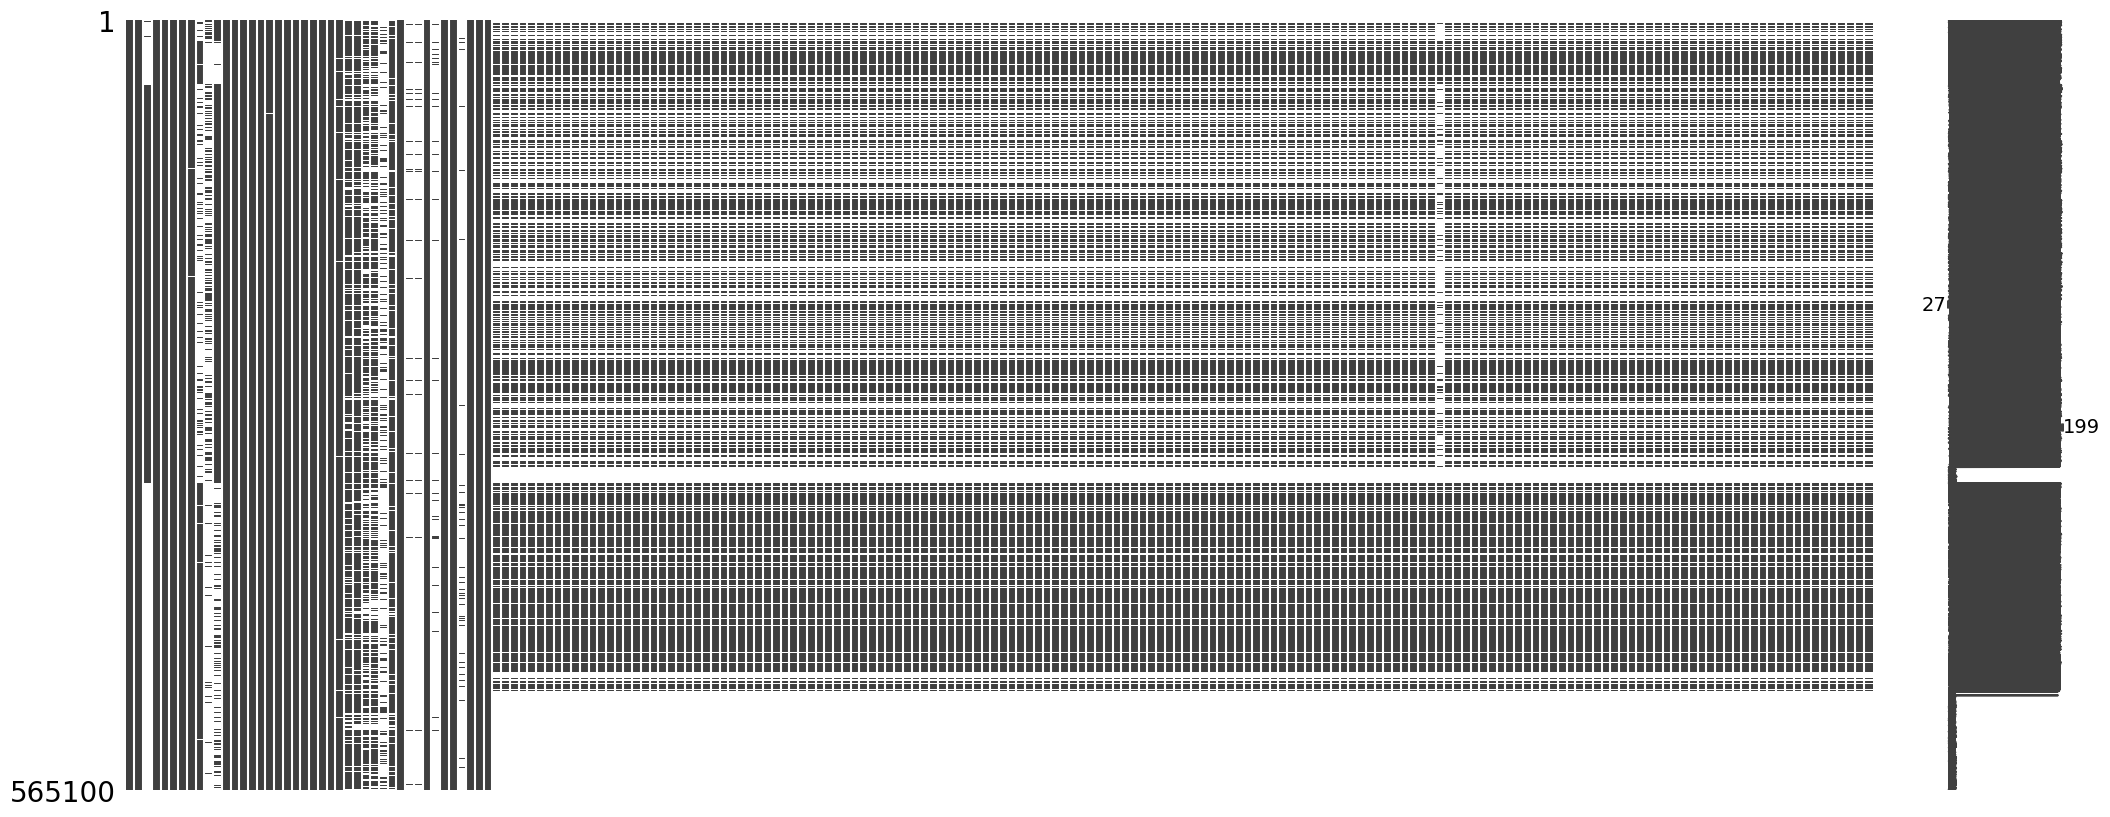

In [18]:
msno.matrix(merged_df)

In [22]:
# compte le nb de valeurs non vides dans la colonne "colonne111_250"
print('Le nombre de valeurs non vides dans la colonne "colonne111_250" est :', merged_df['colonne111_250'].notnull().sum())

# affiche en pourcentage le nb de valeurs non vides dans la colonne "colonne111_250"
print('Le pourcentage de valeurs non vides dans la colonne "colonne111_250" est :', merged_df['colonne111_250'].notnull().sum() / merged_df.shape[0])

Le nombre de valeurs non vides dans la colonne "colonne111_250" est : 331089
Le pourcentage de valeurs non vides dans la colonne "colonne111_250" est : 0.5858945319412493


In [23]:
# exporte merged_df au format csv
merged_df.to_csv('data/spipoll_corineland.csv', index=False)